In [78]:
import pandas as pd
import xgboost as xgb
import numpy as np
import sys
import os
sys.path.append('./../dataProcessing/')
from dataProcessing import GetData
from sklearn.model_selection import train_test_split
import configparser
from os import path
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
import datetime as dt
import datetime


import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## for Deep-learing:
import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

# for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable



# hard code
paths = ['/Users/phamduy/github-res/stock-info/dataProcessing/Data/ext/01_01_2015_31_08_2019']
instance = GetData()
input_data = instance.read_excel(paths)

/Users/phamduy/github-res/stock-info/dataProcessing/Data/ext/01_01_2015_31_08_2019/UPCOM.xls
/Users/phamduy/github-res/stock-info/dataProcessing/Data/ext/01_01_2015_31_08_2019/Index.xls
/Users/phamduy/github-res/stock-info/dataProcessing/Data/ext/01_01_2015_31_08_2019/HOSE.xls
/Users/phamduy/github-res/stock-info/dataProcessing/Data/ext/01_01_2015_31_08_2019/HNX.xls


In [3]:
dataset = input_data.get('index')
dataset.describe()
# dataset=dataset.drop(["OPEN","HIGH","LOW"],axis=1)
# dataset['DATE'] = pd.to_datetime(dataset['DATE'])
# dataset['DATE']=dataset['DATE'].map(dt.datetime.toordinal)

,OPEN,HIGH,LOW,CLOSE
count,3366.000000,3366.000000,3366.000000,3366.000000
mean,292.669002,277.192139,273.884846,293.677885
std,363.256222,376.049137,371.514356,361.670392
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,52.990000
50%,91.115000,52.375000,51.990000,63.435000
75%,609.482500,613.097500,604.872500,610.645000
max,1207.620000,1211.340000,1197.440000,1204.330000


In [4]:
vnindex = dataset.loc[dataset.TICKER=='VNINDEX',: ]
upcomindex = dataset.loc[dataset.TICKER=='UPCOMINDEX',: ]

vnindex["VOLUME"] = pd.to_numeric(vnindex["VOLUME"])
# y = vnindex.pop('CLOSE')
y = vnindex['CLOSE']
X = vnindex.drop(['TICKER'],axis=1)
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
vnindex.drop('TICKER',axis=1)
vnindex['VOLUME'] = abs(vnindex['VOLUME'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
def make_graph(df):
    fig = plt.figure(figsize=(18,16))
    fig.subplots_adjust(hspace=.4)
    ax1 = fig.add_subplot(5,1,1)
    ax1.plot(df['OPEN'],linewidth=1)
    ax1.set_title('OPEN')
    ax1.tick_params(axis='both', which='major')
    
    ax1 = fig.add_subplot(5,1,2)
    ax1.plot(df['CLOSE'],linewidth=1)
    ax1.set_title('CLOSE')
    ax1.tick_params(axis='both', which='major')
    
    ax1 = fig.add_subplot(5,1,3)
    ax1.plot(df['HIGH'],linewidth=1)
    ax1.set_title('HIGH')
    ax1.tick_params(axis='both', which='major')
    
    ax1 = fig.add_subplot(5,1,4)
    ax1.plot(df['LOW'],linewidth=1)
    ax1.set_title('LOW')
    ax1.tick_params(axis='both', which='major')
    
    ax1 = fig.add_subplot(5,1,5)
    ax1.plot(df['VOLUME'],linewidth=1)
    ax1.set_title('VOLUME')
    ax1.tick_params(axis='both', which='major')


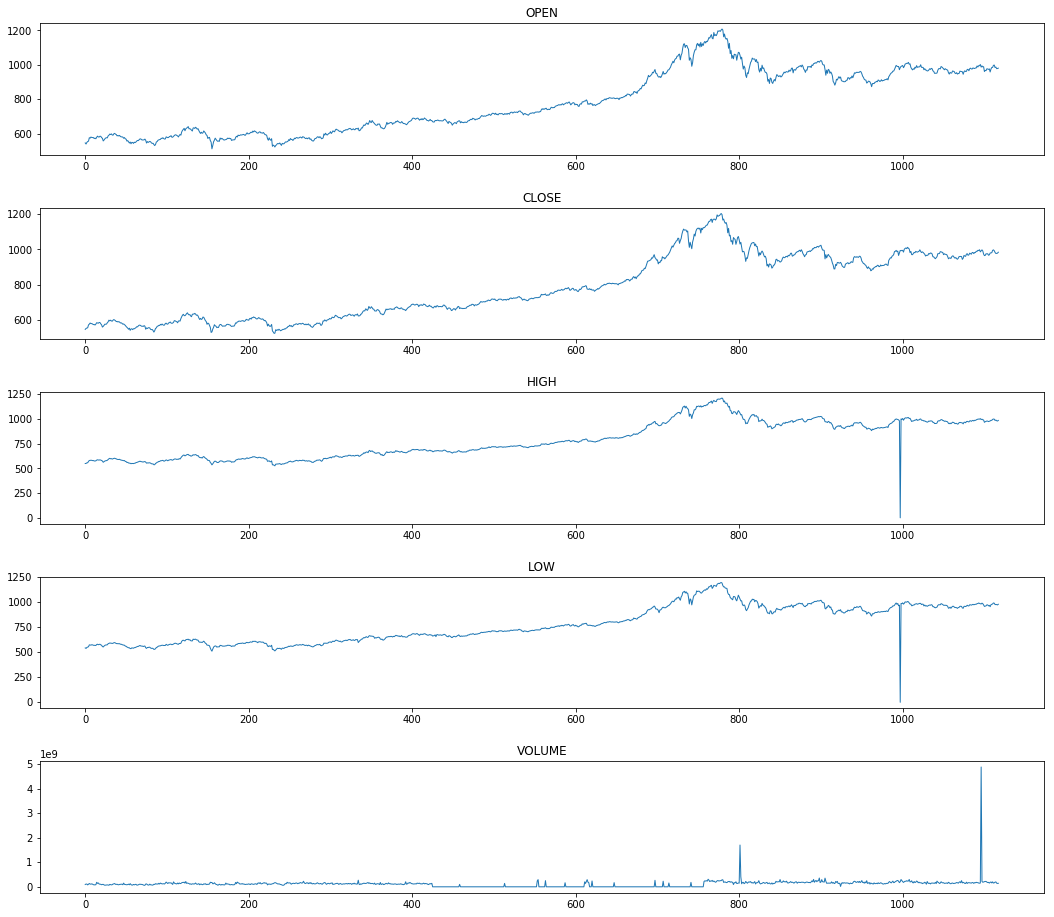

In [7]:
make_graph(vnindex)

In [8]:
# print(X_train.shape)
# print(y_train.shape)

# y_train = np.array(y_train).reshape(len(y_train), 1)
# X_train = np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)

In [9]:
print(X_train.columns)
X_train = X_train.drop(['DATE'],axis=1)
print(X_train.columns)

Index(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'], dtype='object')
Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'], dtype='object')


In [10]:
print(X_train.shape)
print(y_train.shape)

(782, 5)
(782,)


In [31]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
#         print("i {}".format(i))
        x.append(df[i-50:i,])
        y.append(df[i])
#         print("x {} \n y {}".format(x,y))
    x = np.array(x)
    y = np.array(y)
    return x,y

In [37]:
df = vnindex['OPEN'].values
df = df.reshape(-1,1)
print(df.shape)

(1118, 1)


In [41]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(894, 1)
(274, 1)


In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.04924694],
       [0.04012979],
       [0.05356861],
       [0.06081925],
       [0.06374822]])

In [69]:
dataset_test = scaler.fit_transform(dataset_test)
dataset_test[:5]

array([[0.21468518],
       [0.35166787],
       [0.4585828 ],
       [0.43516021],
       [0.38706494]])

In [86]:
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [48]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [65]:
# Model building
length_of_sequence = x_train.shape[1]
in_out_neurons = 1
n_hidden = 128
 
model = Sequential()
# model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=True))
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dense(in_out_neurons))
# model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)
model.summary()
# Learning 
# history = model.fit(x_train, y_train, batch_size=2, epochs=100, validation_split=0.1)
history = model.fit(x_train, y_train,batch_size = 32, epochs=100, validation_split=0.1)
predicted = model.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 300)               362400    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
Train on 759 samples, validate on 85 samples
Epoch 1/100
759/759 [==============================] - 10s 14ms/step - loss: 0.0270 - val_loss: 0.0017
Epoch 2/100
759/759 [==============================] - 7s 9ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 3/100
759/759 [==============================] - 7s 9ms/step - loss: 7.3158e-04 - val_loss: 0.0015
Epoch 4/100
759/759 [==============================] - 7s 9ms/step - loss: 6.4885e-04 - val_loss: 0.0015
Epoch 5/100
759/759 [==============================] - 7s 9ms/step - loss

In [87]:
print(x_test[:1,:5])
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

[[[0.21468518]
  [0.35166787]
  [0.4585828 ]
  [0.43516021]
  [0.38706494]]]


In [88]:
print(r2_score(y_test,predicted))
print(mean_absolute_error(y_test,predicted))
print(mean_squared_error(y_test,predicted))

0.8933808605361196
8.31865325927734
123.28664773460382


In [12]:
# モデルクラス定義
 
class NN(torch.nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        # クラスの初期化
        # :param in_size: 入力層のサイズ
        # :param hidden_size: 隠れ層のサイズ
        # :param out_size: 出力層のサイズ
        super(NN, self).__init__()
        self.xh = torch.nn.Linear(in_size, hidden_size)
        self.hh = torch.nn.Linear(hidden_size, hidden_size)
        self.hy = torch.nn.Linear(hidden_size, out_size)
 
    def __call__(self, x):
        # 順伝播を計算する関数
        # :param x: 入力値
        h = F.relu(self.xh(x))
        h = F.relu(self.hh(h))
        y = F.log_softmax(self.hy(h))
        return y
    
# モデルクラス定義
 
class LSTM(nn.Module):
    def __init__(self, seq_size, hidden_size, out_size):
        # クラスの初期化
        # :param seq_size: 入力時系列のサイズ
        # :param hidden_size: 隠れ層のサイズ
        # :param out_size: 出力層のサイズ
        super(LSTM, self).__init__()
        self.xh = torch.nn.LSTM(seq_size, hidden_size)
        self.hy = torch.nn.Linear(hidden_size, out_size)
        self.hidden_size = hidden_size
 
    def __call__(self, xs):
        # 順伝播を計算する関数
        # :param xs: 入力時系列
        h, self.hidden = self.xh(xs, self.hidden)
        y = self.hy(h)
        return y
 
    def reset(self):
        # メモリの初期化
        self.hidden = (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size))) # h, c
 

In [13]:
# モデルの定義
in_size = X_train.shape[1]
HIDDEN_SIZE = 5
BATCH_COL_SIZE = 10 # ミニバッチで分割する時系列数
EPOCH_NUM = 100

model = LSTM(seq_size=BATCH_COL_SIZE, hidden_size=HIDDEN_SIZE, out_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [42]:
# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):
    # ミニバッチ学習
    x, t = X_train, y_train
    #  ミニバッチ学習データとして、BATCH_ROW_SIZE個用意する
#     for i in range(BATCH_ROW_SIZE):
#         index = np.random.randint(0, N) # ランダムな箇所
#         x.append(train_x[index]) # BATCH_COL_SIZE分の時系列を取り出す
#         t.append(train_t[index])
    x = np.array(x, dtype="float32")
    t = np.array(t, dtype="float32")
    x = Variable(torch.from_numpy(x))
    t = Variable(torch.from_numpy(t))
    total_loss = 0
    model.reset() # メモリの初期化
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    total_loss += loss.data.numpy()[0]
    optimizer.step()
    if (epoch+1) % 100 == 0:
        ed = datetime.datetime.now()
        print("epoch:\t{}\ttotal loss:\t{}\ttime:\t{}".format(epoch+1, total_loss, ed-st))
        st = datetime.datetime.now()
 

Train


RuntimeError: input must have 3 dimensions, got 2